In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import io

from google.colab import files as colab_files
uploaded = colab_files.upload()

Saving olist_customers_dataset.csv to olist_customers_dataset.csv
Saving olist_order_items_dataset.csv to olist_order_items_dataset.csv
Saving olist_order_reviews_dataset.csv to olist_order_reviews_dataset.csv
Saving olist_orders_dataset.csv to olist_orders_dataset.csv


In [ ]:
import numpy as np
import pandas as pd
import networkx as nx

### Read data

In [ ]:
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
orders_dataset = pd.read_csv('olist_orders_dataset.csv')
order_items_dataset = pd.read_csv('olist_order_items_dataset.csv')
customers_dataset = pd.read_csv('olist_customers_dataset.csv')

In [ ]:
# merge these four tables: order_reviews, orders_dataset, order_items_dataset, customers_dataset
df_all_orig = order_reviews.merge(orders_dataset,on='order_id').merge(customers_dataset,on='customer_id').merge(order_items_dataset,on='order_id')

In [ ]:
df = df_all_orig.copy()
df['order_id_int'] = df.order_id.astype('category').cat.rename_categories(range(1, df.order_id.nunique()+1))
df['product_id_int'] = df.product_id.astype('category').cat.rename_categories(range(1, df.product_id.nunique()+1))

In [ ]:
df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,...,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_id_int,product_id_int
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,...,osasco,SP,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.00,13.63,44686,32578
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,...,osasco,SP,2,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.00,13.63,44686,32578
2,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,2018-02-28 12:25:19,...,nova odessa,SP,1,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-06 12:48:39,79.79,8.30,63397,24413
3,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,e226dfed6544df5b7b87a48208690feb,delivered,2018-02-03 09:56:22,...,santo antonio de jesus,BA,1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-02-08 10:31:15,149.00,45.12,96292,27040
4,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,2017-04-09 17:41:13,...,gravatal,SC,1,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2017-04-13 17:55:19,179.99,42.85,39075,10751


In [ ]:
df_all_orig.shape

(113322, 24)

In [ ]:
df.shape

(113322, 26)

In [ ]:
df.isna().sum()

review_id                            0
order_id                             0
review_score                         0
review_comment_title             99700
review_comment_message           64730
review_creation_date                 0
review_answer_timestamp              0
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                   15
order_delivered_carrier_date      1203
order_delivered_customer_date     2475
order_estimated_delivery_date        0
customer_unique_id                   0
customer_zip_code_prefix             0
customer_city                        0
customer_state                       0
order_item_id                        0
product_id                           0
seller_id                            0
shipping_limit_date                  0
price                                0
freight_value                        0
order_id_int                         0
product_id_int           

### Build network

In [ ]:
df_product = df[['order_id_int','product_id_int']].copy()
df_product.shape

(113322, 2)

In [ ]:
order_items_dataset.shape

(112650, 7)

In [ ]:
order_items_dataset.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [ ]:
df_mod = df_product.groupby('order_id_int').count()
df_linked = df_mod[df_mod.product_id_int>1]
df_linked = df_linked.reset_index()
df_linked

,order_id_int,product_id_int
0,14,2
1,32,3
2,40,3
3,44,2
4,70,2
...,...,...
10275,98604,2
10276,98627,2
10277,98638,3
10278,98655,2


In [ ]:
len(df_linked.order_id_int.unique())

10280

In [ ]:
product_id_dict = dict()
order_id_list = df_linked.order_id_int.tolist()
for order in order_id_list:
    product_id_dict[order] = df[df.order_id_int==order].product_id_int.tolist()

In [ ]:
product_id_dict

{14: [7080, 7080],
 32: [30035, 30035, 30035],
 40: [1415, 1415, 1415],
 44: [29660, 29660],
 70: [5995, 5995],
 74: [27347, 17533],
 80: [5742, 5742],
 83: [4187, 2572],
 86: [17783, 17783],
 92: [19796, 19796],
 101: [13102, 13102],
 124: [17176, 17176],
 125: [1583, 1583, 1583, 1583],
 128: [17349, 17349],
 135: [32369, 9904, 9904],
 148: [10695, 10695],
 190: [30898, 30898],
 199: [10114, 20022],
 209: [23379, 12848],
 212: [889, 889],
 229: [11281, 11281, 11281],
 249: [16384, 16384],
 261: [29814, 29814],
 269: [14027, 23594, 26981, 11129],
 277: [15715, 15715],
 295: [3451, 3451, 3451, 3451],
 308: [4651, 4651],
 312: [14711, 14711],
 318: [20987, 20987],
 330: [17533, 17533],
 348: [6236, 6236, 6236, 6236],
 358: [23233, 23233, 23233],
 361: [19941, 19941, 19941],
 367: [12094, 12094],
 374: [2708, 2708],
 390: [14478, 14478, 14478, 14478],
 396: [10841, 10841],
 406: [25072, 25072],
 410: [29965, 29965],
 412: [23724, 18918],
 427: [20439, 20439],
 439: [3087, 2213],
 441: [22

In [ ]:
network_data = list()
for _,value in product_id_dict.items():
    pairs = [[item1, item2] for item1 in value for item2 in value if item1 != item2]
    for pair in pairs:
        network_data.append(pair)

In [ ]:
df_network = pd.DataFrame(network_data, columns=['node1','node2'])

In [ ]:
df_network = df_network.sort_values('node1')
df_network

,node1,node2
9341,6,11727
9340,6,8356
9339,6,26134
5511,10,29064
3647,32,8108
...,...,...
10212,32929,30896
10631,32938,1749
11388,32938,14860
6082,32944,5779


In [ ]:
G_0=nx.from_pandas_edgelist(df_network, 'node1', 'node2')
G = G_0.to_undirected()
len(list(G.edges))

4058

### Data cleaning + Add features

In [ ]:
df

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,...,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_id_int,product_id_int
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,...,osasco,SP,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.00,13.63,44686,32578
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,...,osasco,SP,2,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.00,13.63,44686,32578
2,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,2018-02-28 12:25:19,...,nova odessa,SP,1,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,2018-03-06 12:48:39,79.79,8.30,63397,24413
3,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,e226dfed6544df5b7b87a48208690feb,delivered,2018-02-03 09:56:22,...,santo antonio de jesus,BA,1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-02-08 10:31:15,149.00,45.12,96292,27040
4,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,2017-04-09 17:41:13,...,gravatal,SC,1,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2017-04-13 17:55:19,179.99,42.85,39075,10751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113317,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42,d0d7086dea6fcf42b9b690b9f3745c58,delivered,2017-12-03 21:45:23,...,rio de janeiro,RJ,1,3a33c980b62eb1ef3b8ae61b6fc6fe55,46dc3b2cc0980fb8ec44634e21d2718e,2017-12-07 22:08:00,199.99,9.77,13422,7572
113318,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43,fcc7b1caafe3b77fd587bab964c4d1fb,delivered,2018-03-18 09:52:19,...,lavras,MG,1,8ba0118a487ec8671aed57e5ef846574,17ca9b9e9b9ef8fdb529001b49ebb50f,2018-03-22 10:08:04,215.97,15.59,33074,17952
113319,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13,3aa00401736823c73e9fe8683328fa6b,delivered,2018-06-22 16:47:28,...,betim,MG,1,73a7fbf8c1048131f3b531af31bcdf0e,8d956fec2e4337affcb520f56fd8cbfd,2018-06-26 18:15:29,50.95,15.46,45825,15004
113320,be360f18f5df1e0541061c87021e6d93,f8bd3f2000c28c5342fedeb5e50f2e75,1,NaN,Solicitei a compra de uma capa de retrovisor c...,2017-12-15 00:00:00,2017-12-16 01:29:43,8df587ce8a11ee97b3de9ef3405245c2,delivered,2017-12-10 18:44:23,...,sorocaba,SP,1,54caa022e792f1ce31d4a656cecaa802,25cf099de44674fde97473224f9d59ab,2017-12-19 03:59:36,10.00,7.78,95850,11021


In [ ]:
df.review_comment_title.unique()

array([nan, 'recomendo', 'Super recomendo', ..., 'muito bom produto ',
       'Não foi entregue o pedido', 'Foto enganosa '], dtype=object)

In [ ]:
df = df.sort_values('product_id_int')

In [ ]:
df.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'order_id_int', 'product_id_int'],
      dtype='object')

In [ ]:
df_features = df.copy()

In [ ]:
df_features['order_delivered_customer_date'] = pd.to_datetime(df.order_delivered_customer_date)
df_features['order_estimated_delivery_date'] = pd.to_datetime(df.order_estimated_delivery_date)
df_features['order_purchase_timestamp'] = pd.to_datetime(df.order_purchase_timestamp)
df_features['shipping_limit_date'] = pd.to_datetime(df.shipping_limit_date)

In [ ]:
df_features['order_delivery_over_limit_date'] = df_features.shipping_limit_date - df_features.order_delivered_customer_date
df_features['order_delivery_over_limit_date'] = df_features['order_delivery_over_limit_date'] / np.timedelta64(1,'D')

In [ ]:
df_features['order_delivery_duration_over'] = df_features.order_delivered_customer_date - df_features.order_estimated_delivery_date
df_features['order_delivery_duration_over'] = df_features['order_delivery_duration_over'] / np.timedelta64(1,'D')

In [ ]:
df_features['order_estimated_delivery_duration'] = df_features.order_estimated_delivery_date - df_features.order_purchase_timestamp
df_features['order_estimated_delivery_duration'] = df_features['order_estimated_delivery_duration'] / np.timedelta64(1,'D')

In [ ]:
df_features['is_late'] = np.where(df_features.order_estimated_delivery_duration > 0, 1, 0)
df_features['have_comment'] = np.where(df_features.review_comment_message.isnull(), 0, 1)

In [ ]:
df_features.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'order_id_int', 'product_id_int',
       'order_delivery_over_limit_date', 'order_delivery_duration_over',
       'order_estimated_delivery_duration', 'is_late', 'have_comment'],
      dtype='object')

In [ ]:
df_clean = df_features[['product_id_int',
                         'freight_value','price',
                          'customer_state','customer_city',
                          'order_delivery_over_limit_date',
                          'order_delivery_duration_over',
                          'order_estimated_delivery_duration', 
                          'is_late', 'have_comment',
                          'review_score']].copy()

#### label encoding state and city

In [ ]:
df_clean.isna().sum()

product_id_int                          0
freight_value                           0
price                                   0
customer_state                          0
customer_city                           0
order_delivery_over_limit_date       2475
order_delivery_duration_over         2475
order_estimated_delivery_duration       0
is_late                                 0
have_comment                            0
review_score                            0
dtype: int64

In [ ]:
df_clean.shape

(113322, 11)

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df_clean.customer_state.unique().tolist())
df_clean['customer_state'] = le.transform(df_clean.customer_state.tolist())

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(df_clean.customer_city.unique().tolist())
df_clean['customer_city'] = le.transform(df_clean.customer_city.tolist())

In [ ]:
df_clean = df_clean.dropna()

In [ ]:
df_clean.shape

(110847, 11)

In [ ]:
df_clean

,product_id_int,freight_value,price,customer_state,customer_city,order_delivery_over_limit_date,order_delivery_duration_over,order_estimated_delivery_duration,is_late,have_comment,review_score
82394,1,18.59,101.65,22,3845,-13.133993,-13.075046,30.218507,1,0,5
97614,2,13.93,129.90,25,1379,-4.902454,-12.283437,23.194120,1,0,4
98586,3,13.10,229.00,25,3588,-7.952141,-9.372442,25.318206,1,1,1
79666,4,19.60,58.90,22,1311,-1.332164,-9.101620,16.441262,1,1,5
55036,4,19.60,58.90,22,2546,0.191979,-16.264676,22.082951,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...
56196,32950,7.39,34.99,25,3588,3.972373,-11.227222,13.269664,1,0,5
3778,32950,18.23,34.99,10,1058,-0.311331,-19.250764,25.574861,1,0,5
45214,32950,7.51,34.99,25,3588,-0.082593,-0.212106,2.327812,1,0,5
3974,32950,7.51,34.99,25,3588,-0.142766,-0.131331,4.281169,1,0,5


In [ ]:
linked_product_list = df_network.node1.unique().tolist()

In [ ]:
len(linked_product_list)

4885

In [ ]:
df_nodes_with_link = df_clean[df_clean.product_id_int.isin(linked_product_list)].copy()
df_nodes_without_link = df_clean[~df_clean.product_id_int.isin(linked_product_list)].copy()

In [ ]:
from collections import OrderedDict 

# get clustering coefficient for nodes
cluster = nx.clustering(G)
cluster_asc = OrderedDict(sorted(cluster.items()))

# get degree centrality
degree_centrality = nx.degree_centrality(G)
degree_centrality_asc = OrderedDict(sorted(degree_centrality.items()))

# get closeness centrality
closeness_centrality = nx.closeness_centrality(G)
closeness_centrality_asc = OrderedDict(sorted(closeness_centrality.items()))

# get betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
betweenness_centrality_asc = OrderedDict(sorted(betweenness_centrality.items()))

# get degree of nodes
degree = G.degree(linked_product_list)

In [ ]:
df_nodes_with_link.shape

(40709, 11)

In [ ]:
df_nodes_without_link.shape

(70138, 11)

In [ ]:
len([item for item in df_nodes_with_link.product_id_int if item in linked_product_list])

40709

In [ ]:
len([value for value in linked_product_list])

4885

In [ ]:
df_nodes_with_link['cluster'] = [cluster_asc[value] for value in df_nodes_with_link.product_id_int.tolist()]
df_nodes_without_link['cluster'] = [0 for i in range(len(df_nodes_without_link.product_id_int))]

df_nodes_with_link['d_centrality'] = [degree_centrality_asc[value] for value in df_nodes_with_link.product_id_int.tolist()]
df_nodes_without_link['d_centrality'] = [0 for i in range(len(df_nodes_without_link.product_id_int))]

df_nodes_with_link['c_centrality'] = [closeness_centrality_asc[value] for value in df_nodes_with_link.product_id_int.tolist()]
df_nodes_without_link['c_centrality'] = [0 for i in range(len(df_nodes_without_link.product_id_int))]

df_nodes_with_link['b_centrality'] = [betweenness_centrality_asc[value] for value in df_nodes_with_link.product_id_int.tolist()]
df_nodes_without_link['b_centrality'] = [0 for i in range(len(df_nodes_without_link.product_id_int))]

df_nodes_with_link['degree'] = [degree[value] for value in df_nodes_with_link.product_id_int.tolist()]
df_nodes_without_link['degree'] = [0 for i in range(len(df_nodes_without_link.product_id_int))]

df_set = df_nodes_with_link.append(df_nodes_without_link, ignore_index=True)

In [ ]:
df_set

,product_id_int,freight_value,price,customer_state,customer_city,order_delivery_over_limit_date,order_delivery_duration_over,order_estimated_delivery_duration,is_late,have_comment,review_score,cluster,d_centrality,c_centrality,b_centrality,degree
0,6,15.80,52.00,10,2917,-0.746354,-19.393588,28.145498,1,1,1,1.0,0.000614,0.001008,0.0,3
1,10,8.72,34.99,25,3588,-2.341192,-4.136817,12.485150,1,0,5,0.0,0.000205,0.000205,0.0,1
2,10,15.10,34.99,18,3092,-1.639039,-13.205799,22.244062,1,1,5,0.0,0.000205,0.000205,0.0,1
3,10,9.90,34.99,25,1090,-0.292847,-5.182662,12.481343,1,1,5,0.0,0.000205,0.000205,0.0,1
4,10,8.72,34.99,25,3588,3.033229,-13.150220,16.127292,1,0,5,0.0,0.000205,0.000205,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110842,32950,7.39,34.99,25,3588,3.972373,-11.227222,13.269664,1,0,5,0.0,0.000000,0.000000,0.0,0
110843,32950,18.23,34.99,10,1058,-0.311331,-19.250764,25.574861,1,0,5,0.0,0.000000,0.000000,0.0,0
110844,32950,7.51,34.99,25,3588,-0.082593,-0.212106,2.327812,1,0,5,0.0,0.000000,0.000000,0.0,0
110845,32950,7.51,34.99,25,3588,-0.142766,-0.131331,4.281169,1,0,5,0.0,0.000000,0.000000,0.0,0


In [ ]:
df_set.isna().sum()

product_id_int                       0
freight_value                        0
price                                0
customer_state                       0
customer_city                        0
order_delivery_over_limit_date       0
order_delivery_duration_over         0
order_estimated_delivery_duration    0
is_late                              0
have_comment                         0
review_score                         0
cluster                              0
d_centrality                         0
c_centrality                         0
b_centrality                         0
degree                               0
dtype: int64

### Modeling

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import mord
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

In [ ]:
X = df_set.drop(columns=['review_score','product_id_int'])
y = df_set.review_score

In [ ]:
X_train_val,X_test,y_train_val,y_test = train_test_split(X,y,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train_val,y_train_val,test_size=0.2)

In [ ]:
def regression_model(reg_model):
    pipe = Pipeline([('scaler1', MinMaxScaler()),('scaler2', StandardScaler()), ('reg',reg_model)])
    pipe.fit(X_train,y_train)
    y_val_pred = pipe.predict(X_val)
    mae = mean_absolute_error(y_val,y_val_pred)
    mse = mean_squared_error(y_val,y_val_pred)
    rmse = np.sqrt(mse)
    return mae, rmse

In [ ]:
xg_reg = XGBRegressor(objective ='reg:squarederror', random_state=0, n_estimators = 50)
mul_lr = mord.OrdinalRidge(alpha=0.001, 
                           fit_intercept=True, 
                           normalize=False, 
                           copy_X=True, 
                           max_iter=None, 
                           tol=0.001, 
                           solver='auto')
ml_models = [DummyRegressor(strategy='mean'),KNeighborsRegressor(),xg_reg,AdaBoostRegressor(),GradientBoostingRegressor(),
             RandomForestRegressor(),LinearRegression(),Lasso(),Ridge(),mul_lr,MLPRegressor()]

In [ ]:
performance = []
for model in ml_models:
    print(ml_models.index(model)+1)
    performance.append(regression_model(model))

1
2
3
4
5
6
7
8
9
10
11


In [ ]:
performance_df = pd.DataFrame(performance, columns=['MAE','RMSE'])
performance_df['Regression_models'] = ['Dummy','KNN','XGBoost','AdaBoost','GradientBoost','RandomForest','Linear','Lasso','Ridge','OrdinalLogistic','MLP']
performance_df = performance_df[['Regression_models','MAE','RMSE']]

In [ ]:
performance_df

,Regression_models,MAE,RMSE
0,Dummy,1.069608,1.361061
1,KNN,0.933829,1.270778
2,XGBoost,0.925555,1.185189
3,AdaBoost,1.021677,1.226728
4,GradientBoost,0.941285,1.196362
5,RandomForest,0.843959,1.105439
6,Linear,0.984709,1.245465
7,Lasso,1.069608,1.361061
8,Ridge,0.984711,1.245465
9,OrdinalLogistic,0.943505,1.285918


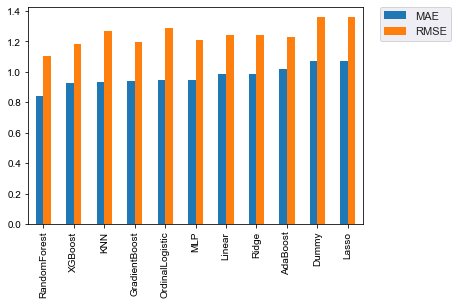

In [ ]:
performance_df.sort_values(by='MAE').plot(kind='bar')
sns.set(rc={'figure.figsize':(10,5)})
sns.set(font_scale = 1)
plt.xticks(range(11),performance_df.sort_values(by='MAE').Regression_models,rotation='vertical')
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)  
plt.show()

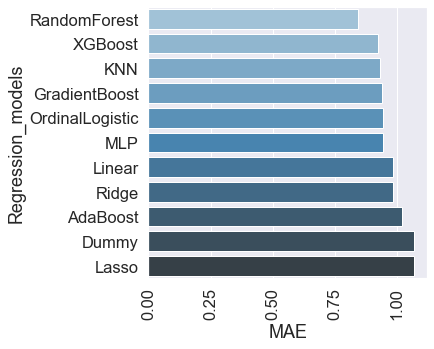

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
sns.set(font_scale = 1.5)
sns.barplot(x='Regression_models',y='MAE',data=performance_df.sort_values(by='MAE'), palette="Blues_d")
plt.xticks(rotation='vertical')
plt.show()

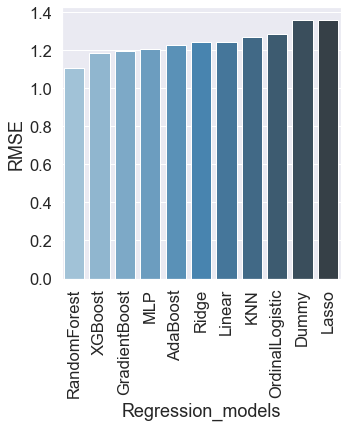

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
sns.set(font_scale = 1.5)
sns.barplot(x='Regression_models',y='RMSE',data=performance_df.sort_values(by='RMSE'), palette="Blues_d")
plt.xticks(rotation='vertical')
plt.show()

### tuning hyperparameters

In [ ]:
# Random Forest
from sklearn.model_selection import GridSearchCV
pipe = Pipeline([('scaler1', MinMaxScaler()),('scaler2', StandardScaler()), ('RF',RandomForestRegressor())])
param_grid = [{
        'RF__n_estimators' : [100,150,200],
        'RF__min_samples_leaf' : [1,3,5,10],
        }]
CV_RF = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = 'neg_mean_absolute_error')
CV_RF.fit(X_train_val, y_train_val)
print(CV_RF.best_score_)
print(CV_RF.best_params_)
y_pred = CV_RF.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(test_mae, test_rmse)

-0.8357804086966276
{'RF__min_samples_leaf': 1, 'RF__n_estimators': 200}
0.8196878662501378 1.0764644832651102


In [ ]:
# XGBoost
pipe = Pipeline([('scaler1', MinMaxScaler()),('scaler2', StandardScaler()), ('xgbrg', XGBRegressor(objective ='reg:squarederror', random_state=0, n_estimators = 50))])
param_grid = {
    "xgbrg__n_estimators": [10, 50, 100, 500],
    "xgbrg__learning_rate": [0.1, 0.5, 1],
}

CV_XGB = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring = 'neg_mean_absolute_error')
CV_XGB.fit(X_train_val, y_train_val)
print(CV_XGB.best_score_)
print(CV_XGB.best_params_)

y_pred = CV_XGB.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(test_mae, test_rmse)

-0.8958427007305314
{'xgbrg__learning_rate': 0.5, 'xgbrg__n_estimators': 500}
0.868397104184962 1.1575260596720967


In [ ]:
# GBDT
pipe = Pipeline([('scaler1', MinMaxScaler()),('scaler2', StandardScaler()), ('GBDT',GradientBoostingRegressor())])
param_grid = [{
        'GBDT__n_estimators' : [100,150,200],
        'GBDT__min_samples_leaf' : [1,3,5,10],
        'GBDT__max_depth': [3,5,10]
        }]
CV_GBDT = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = 'neg_mean_absolute_error',cv=3)
CV_GBDT.fit(X_train_val, y_train_val)
print(CV_GBDT.best_score_)
print(CV_GBDT.best_params_)

y_pred = CV_GBDT.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(test_mae, test_rmse)

-0.8824158514240746
{'GBDT__max_depth': 10, 'GBDT__min_samples_leaf': 5, 'GBDT__n_estimators': 200}
0.8719333918118354 1.1292402911565607
